In [2]:
import pandas as pd

# Chemin vers le fichier Excel d'entr√©e
chemin_fichier = r"C:\Users\andde\Documents\S C O L A I R E\I N S A\5A\PIRD\Etude exp√©rimentale\Sc√©narios\Regroupement r√©sultats 2.0\Donn√©es_combinees.xlsx"

# Charger le fichier Excel, ignorer les colonnes "Unnamed"
data = pd.read_excel(chemin_fichier)
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

# Colonnes principales (fixes)
colonnes_principales = ['Date/Heure', 'Temp√©rature S√®che Air Ext√©rieur', 'Sc√©nario']

# Extraire les colonnes des zones et indicateurs
colonnes_zones = [col for col in data.columns if col not in colonnes_principales]

# Cr√©er une liste pour stocker les nouvelles donn√©es restructur√©es
donnees_restructurees = []

# Parcourir chaque ligne pour transformer les donn√©es
for index, row in data.iterrows():
    for colonne in colonnes_zones:
        zone, indicateur = colonne.split(' ', 1)  # Diviser par le premier espace
        donnees_restructurees.append({
            'Date/Heure': row['Date/Heure'],
            'Temp√©rature S√®che': row['Temp√©rature S√®che Air Ext√©rieur'],
            'Sc√©nario': row['Sc√©nario'],
            'Zone': zone,
            'Indicateur': indicateur,
            'Valeur': row[colonne]
        })

# Convertir la liste en DataFrame
df_restructure = pd.DataFrame(donnees_restructurees)

# Supprimer les lignes avec "Unnamed" dans la colonne Indicateur
df_restructure = df_restructure[~df_restructure['Indicateur'].str.contains('^Unnamed')]

# Sauvegarder le fichier restructur√©
chemin_sortie_final = r"C:\Users\andde\Documents\S C O L A I R E\I N S A\5A\PIRD\Etude exp√©rimentale\Sc√©narios\Regroupement r√©sultats 2.0\Donn√©es_restructur√©es_3.0.xlsx"
df_restructure.to_excel(chemin_sortie_final, index=False, engine='openpyxl')

print(f"Tableau restructur√© sauvegard√© dans : {chemin_sortie_final}")

Tableau restructur√© sauvegard√© dans : C:\Users\andde\Documents\S C O L A I R E\I N S A\5A\PIRD\Etude exp√©rimentale\Sc√©narios\Regroupement r√©sultats 2.0\Donn√©es_restructur√©es_3.0.xlsx


In [67]:
pip install pandas openpyxl xlsxwriter dash tqdm dash-extensions

  Obtaining dependency information for dash-extensions from https://files.pythonhosted.org/packages/5a/f6/3d8d4071428394029a12f8fa7447756d435606579de48df2ff791da38f0e/dash_extensions-1.0.19-py3-none-any.whl.metadata
  Obtaining dependency information for Flask-Caching<3.0.0,>=2.1.0 from https://files.pythonhosted.org/packages/aa/da/8e3ba9735253c6ba440358fcfda89cf5e199467b6ed2baaf6b1e1022b15f/Flask_Caching-2.3.0-py3-none-any.whl.metadata
  Obtaining dependency information for dataclass-wizard<0.31.0,>=0.30.1 from https://files.pythonhosted.org/packages/21/c4/1698067427e6fd5bff407cafe5ba1b3cf109b92e2b064d2e4b4f73379bc3/dataclass_wizard-0.30.1-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/45.8 kB ? eta -:--:--
     ---------------------------------------- 45.8/45.8 kB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/75.6 kB ? eta -:--:--
     ---------------------------------------- 75.6/75.6 kB 2.1 MB/s eta 0:00:00
  Installing buil

In [70]:
pip install --upgrade pydantic typing_extensions dash_extensions

Note: you may need to restart the kernel to use updated packages.


In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
import plotly.express as px
from dash import Dash, dcc, html, Input, Output
import seaborn as sns
import plotly.graph_objects as go
import numpy as np
from scipy.stats import gaussian_kde
from dash import dash_table

In [73]:
# =======================================================================
# √âtape 1 : Pr√©paration des donn√©es pour les sc√©narios
# =======================================================================

# Ventilation
ventilation_params = pd.DataFrame({
    'Sc√©nario': ['V2', 'V3', 'V4', 'V5'],
    'M√©thode de ventilation': ['M√©canique', 'Naturelle', 'Naturelle', 'Hybride'],
    'Type de contr√¥le': ['Delta T'] * 4,
    'D√©bit d\'air ext√©rieur (Vol/h)': [15] * 4,
    'Delta T (deltaC)': [1, 2, 1, 1],
    'Planning': ['Night_Ventilation', 'Night_Ventilation', 'TM59_Living/Kitchen_Occ', 'Night_Ventilation'],
    'Temp√©rature min. ext√©rieure (¬∞C)': [0, 0, 15, 15],
    'Temp√©rature max. ext√©rieure (¬∞C)': [30, 30, 28, 30]
})

# Ombrage
ombrage_params = pd.DataFrame({
    'Sc√©nario': ['O1', 'O2', 'O3'],
    'Type de contr√¥le': ['Toujours actif'] * 3,
    'Espacement des lames (en m)': [0.3, None, None],
    'Angle (en ¬∞)': [15, 'Horizontal', None],
    'Distance √† la fen√™tre (en m)': [0.3, None, 0.05],
    'Profondeur Lame (en m)': [0.4, 1, None],
    '√âpaisseur (en m)': [0.002, 0.002, 0.003],
    'Conductivit√© (en W/m¬∑K)': [None, None, 0.1],
    'Transmission solaire': [None, None, 0.4]
})

# Vitrage
vitrage_params = pd.DataFrame({
    'Sc√©nario': ['G3', 'G4'],
    'Coefficient de gain de chaleur': [0.419, 0.287],
    'Transmission solaire directe': [0.345, 0.22],
    'Transmission de lumi√®re': [0.682, 0.393],
    'Coefficient (en W/m¬≤¬∑K)': [1.338, 1.267]
})

# Isolant
insulation_params = pd.DataFrame({
    'Mat√©riau': ['MW Glass Wool (standard board)'],
    'M√©thode de d√©finition': ['1- Couches'],
    '√âpaisseur (m)': [0.16]
})

# =======================================================================
# √âtape 2 : Cr√©ation de l'application Dash
# =======================================================================

app = Dash(__name__)

# Layout de l'application
app.layout = html.Div([
    html.H1("D√©tails des sc√©narios", style={'text-align': 'center', 'color': '#2E86C1'}),

    # S√©lections des sc√©narios
    html.Div([
        html.Div([
            html.Label("S√©lectionner un sc√©nario de ventilation :", style={'font-weight': 'bold'}),
            dcc.Dropdown(
                id='ventilation-dropdown',
                options=[{'label': row['Sc√©nario'], 'value': row['Sc√©nario']} for _, row in ventilation_params.iterrows()],
                value=ventilation_params['Sc√©nario'].iloc[0],  # Valeur par d√©faut
                style={'width': '90%'}
            ),
        ], style={'width': '30%', 'display': 'inline-block', 'padding': '10px', 'text-align': 'center'}),

        html.Div([
            html.Label("S√©lectionner un sc√©nario d'ombrage :", style={'font-weight': 'bold'}),
            dcc.Dropdown(
                id='ombrage-dropdown',
                options=[{'label': row['Sc√©nario'], 'value': row['Sc√©nario']} for _, row in ombrage_params.iterrows()],
                value=ombrage_params['Sc√©nario'].iloc[0],  # Valeur par d√©faut
                style={'width': '90%'}
            ),
        ], style={'width': '30%', 'display': 'inline-block', 'padding': '10px', 'text-align': 'center'}),

        html.Div([
            html.Label("S√©lectionner un sc√©nario de vitrage :", style={'font-weight': 'bold'}),
            dcc.Dropdown(
                id='vitrage-dropdown',
                options=[{'label': row['Sc√©nario'], 'value': row['Sc√©nario']} for _, row in vitrage_params.iterrows()],
                value=vitrage_params['Sc√©nario'].iloc[0],  # Valeur par d√©faut
                style={'width': '90%'}
            ),
        ], style={'width': '30%', 'display': 'inline-block', 'padding': '10px', 'text-align': 'center'}),
    ]),

    # D√©tails des sc√©narios s√©lectionn√©s
    html.Div(id='scenario-details', style={'margin-top': '20px', 'text-align': 'center'})
])

# Callbacks pour afficher les d√©tails des sc√©narios
@app.callback(
    Output('scenario-details', 'children'),
    [Input('ventilation-dropdown', 'value'),
     Input('ombrage-dropdown', 'value'),
     Input('vitrage-dropdown', 'value')]
)
def display_scenario_details(selected_ventilation, selected_ombrage, selected_vitrage):
    # Filtrer les donn√©es des sc√©narios s√©lectionn√©s
    ventilation_data = ventilation_params[ventilation_params['Sc√©nario'] == selected_ventilation]
    ombrage_data = ombrage_params[ombrage_params['Sc√©nario'] == selected_ombrage]
    vitrage_data = vitrage_params[vitrage_params['Sc√©nario'] == selected_vitrage]
    insulation_data = insulation_params

    # Fonction pour convertir un DataFrame en tableau HTML
    def dataframe_to_table(data, title, title_color='#1F618D', value_color='#2E4053'):
        return html.Div([
            html.H4(title, style={'text-align': 'center', 'color': title_color, 'margin-bottom': '10px'}),
            html.Table([
                html.Thead(html.Tr([html.Th(col, style={'background-color': '#AED6F1'}) for col in data.columns])),
                html.Tbody([
                    html.Tr([
                        html.Td(data.iloc[0][col], style={'text-align': 'center', 'color': value_color, 'padding': '5px'}) 
                        for col in data.columns
                    ])
                ])
            ], style={
                'width': '80%', 
                'margin': '0 auto', 
                'border': '1px solid black', 
                'border-collapse': 'collapse', 
                'text-align': 'center'
            })
        ])

    # Construire l'affichage
    return html.Div([
        dataframe_to_table(ventilation_data, "D√©tails de la ventilation"),
        dataframe_to_table(ombrage_data, "D√©tails de l'ombrage"),
        dataframe_to_table(vitrage_data, "D√©tails du vitrage"),
        dataframe_to_table(insulation_data, "D√©tails de l'isolant utilis√©")
    ])

# Lancer l'application
if __name__ == '__main__':
    app.run_server(debug=True, port=8071)

In [6]:
# ===================================================================================================================================
# 1. D√©composition et pr√©paration des donn√©es
# ===================================================================================================================================

# Chargement des donn√©es
chemin_fichier = r"C:\Users\andde\Documents\S C O L A I R E\I N S A\5A\PIRD\Etude exp√©rimentale\Sc√©narios\Regroupement r√©sultats 2.0\Donn√©es_restructur√©es_3.0.xlsx"
df = pd.read_excel(chemin_fichier)

# Transformation des dates
df['Date/Heure'] = pd.to_datetime(df['Date/Heure'])  # Convertir en datetime pour faciliter les analyses temporelles
df['Jour'] = df['Date/Heure'].dt.date  # Extraire les jours
df['Mois'] = df['Date/Heure'].dt.month  # Extraire les mois
df['Semaine'] = df['Date/Heure'].dt.isocalendar().week  # Extraire les semaines

# Extraction des param√®tres des sc√©narios
df['Ventilation'] = df['Sc√©nario'].str.extract(r'(V\d+)')  # Extraire le code ventilation (ex : V1, V2)
df['Ombrage'] = df['Sc√©nario'].str.extract(r'(O\d+)')  # Extraire le code ombrage (ex : O1, O2)
df['Vitrage'] = df['Sc√©nario'].str.extract(r'(G\d+)')  # Extraire le code vitrage (ex : G1, G2)

# Moyennes des valeurs par zone et indicateur
zones_summary = df.groupby(['Zone', 'Indicateur'])['Valeur'].mean().reset_index()

# Moyennes des valeurs par sc√©nario et indicateur
scenarios_summary = df.groupby(['Sc√©nario', 'Indicateur'])['Valeur'].mean().reset_index()

# Moyennes par combinaison de param√®tres
params_summary = df.groupby(['Ventilation', 'Ombrage', 'Vitrage', 'Indicateur'])['Valeur'].mean().reset_index()

# Total des heures d'inconfort par zone et sc√©nario
heatmap_data_sum = df[df['Indicateur'] == "Heures d'inconfort (tout type de v√™tement)"].pivot_table(
    index='Zone', columns='Sc√©nario', values='Valeur', aggfunc='sum'
)

# D√©finition des plages d'inconfort (1 √† 8 heures)
df['Plage_inconfort'] = pd.cut(
    df[df['Indicateur'] == "Heures d'inconfort (tout type de v√™tement)"]['Valeur'],
    bins=list(range(0, 9)),  # Plages de 1 √† 8 heures
    labels=[str(i) for i in range(1, 9)]  # Labels pour les plages
)

# Tri des donn√©es pour r√©soudre les √©ventuels retours en arri√®re dans les graphiques temporels
df = df.sort_values(by=['Sc√©nario', 'Zone', 'Date/Heure'])

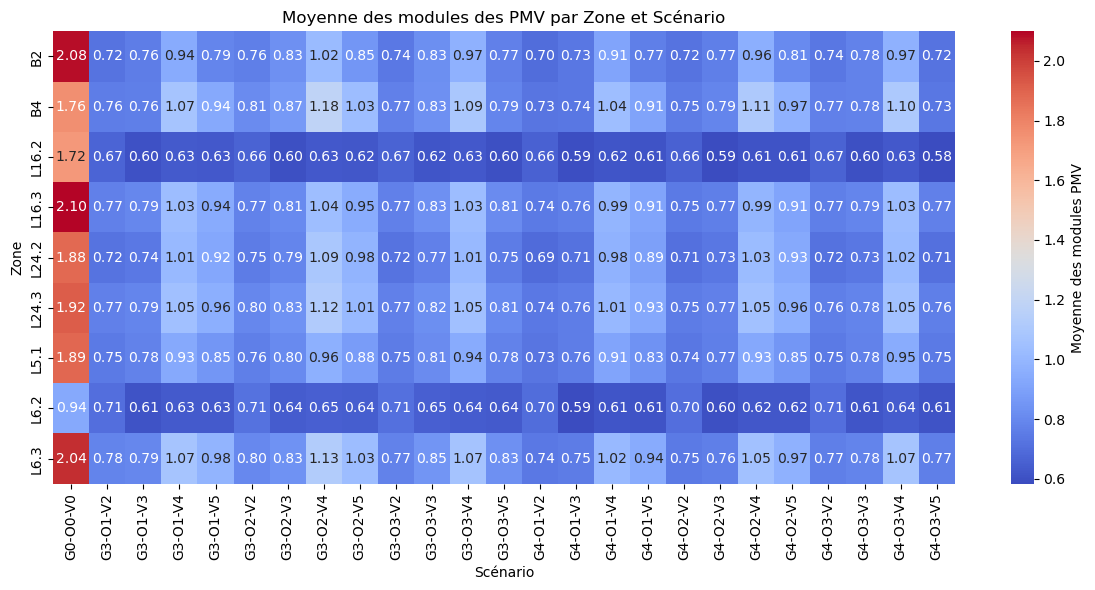

In [19]:
# =======================================================================
# Graphique 1 : Total d'heures d'inconfort par zone et sc√©nario
# =======================================================================

# √âtape 1 : Calcul des moyennes des modules des PMV par zone et sc√©nario
# Filtrer les donn√©es pour le PMV
pmv_data = df[df['Indicateur'] == "Fanger PMV"].copy()  # Utiliser .copy() pour √©viter le Warning

# Ajouter une colonne avec les modules des valeurs de PMV
pmv_data['Valeur_absolue'] = pmv_data['Valeur'].abs()

# Calcul de la moyenne des modules des PMV par zone et sc√©nario
heatmap_data_pmv_abs = pmv_data.pivot_table(
    index='Zone', 
    columns='Sc√©nario', 
    values='Valeur_absolue', 
    aggfunc='mean'  # Moyenne des modules
    
)

# √âtape 2 : Cr√©ation du graphique
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data_pmv_abs, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Moyenne des modules PMV'})
plt.title("Moyenne des modules des PMV par Zone et Sc√©nario")
plt.xlabel("Sc√©nario")
plt.ylabel("Zone")
plt.tight_layout()
plt.show()

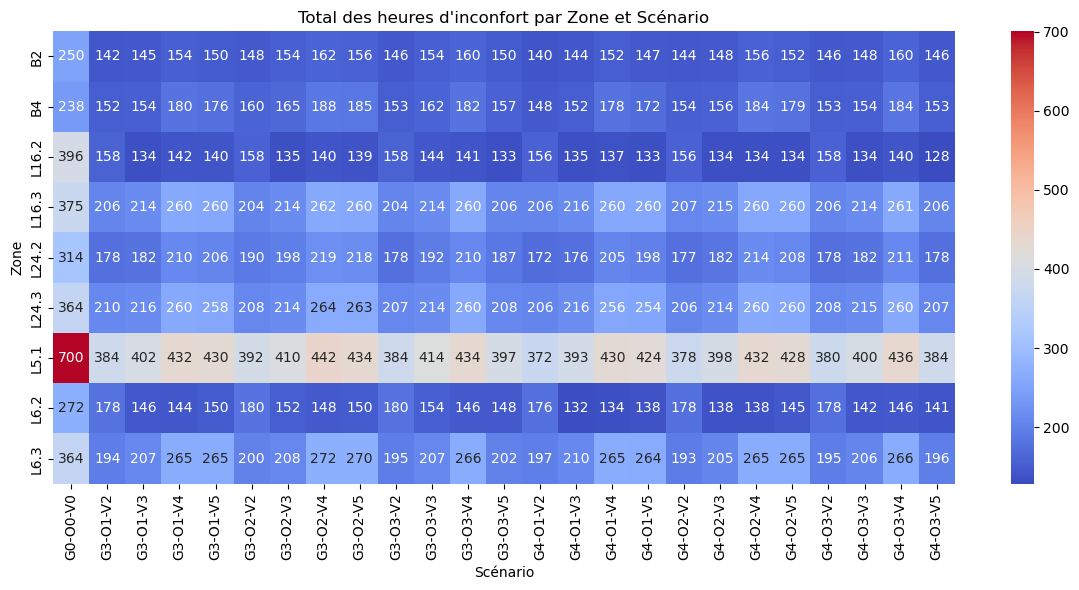

In [7]:
# =======================================================================
# Graphique 2 : Total d'heures d'inconfort par zone et sc√©nario
# =======================================================================
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data_sum, annot=True, cmap='coolwarm', fmt='.0f')
plt.title("Total des heures d'inconfort par Zone et Sc√©nario")
plt.tight_layout()
plt.show()

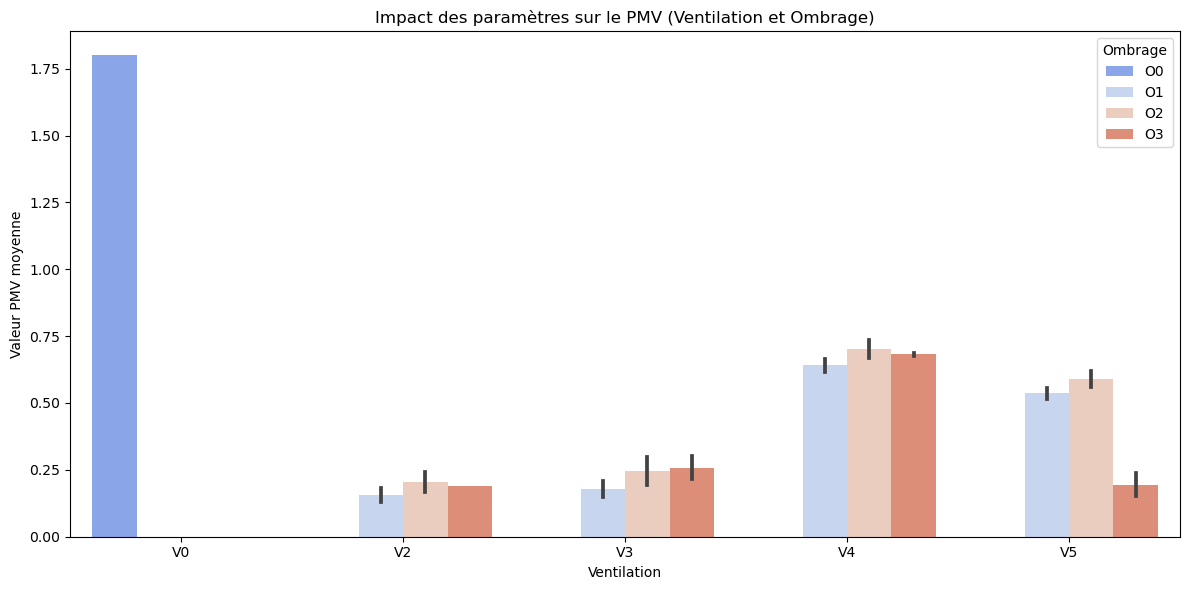

In [8]:
# =======================================================================
# Graphique 3 : Impact des param√®tres sur le PMV (2D)
# =======================================================================
plt.figure(figsize=(12, 6))
sns.barplot(data=params_summary[params_summary['Indicateur'] == "Fanger PMV"], 
            x='Ventilation', y='Valeur', hue='Ombrage', palette='coolwarm')
plt.title("Impact des param√®tres sur le PMV (Ventilation et Ombrage)")
plt.xlabel("Ventilation")
plt.ylabel("Valeur PMV moyenne")
plt.legend(title="Ombrage")
plt.tight_layout()
plt.show()

In [75]:
# =======================================================================
# Graphique 4 : Impact des param√®tres sur le PMV (3D)
# =======================================================================
fig = px.scatter_3d(
    params_summary[params_summary['Indicateur'] == "Fanger PMV"],
    x='Ventilation', y='Ombrage', z='Valeur', color='Vitrage',
    title="Impact des param√®tres sur le PMV (3D)",
    labels={'Ventilation': 'Ventilation', 'Ombrage': 'Ombrage', 'Valeur': 'PMV'},
    height=800, width=1000
)
fig.show()

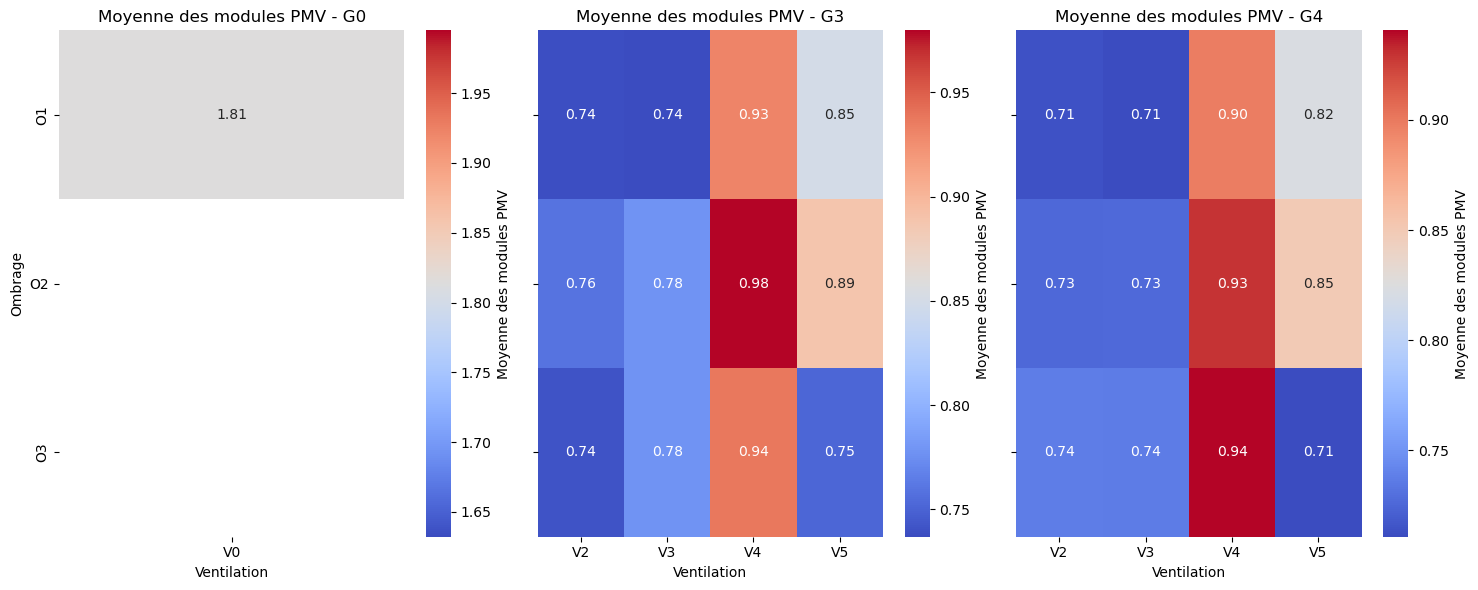

In [10]:
# =======================================================================
# Graphique 5 : Moyenne (modules des PMV) en fonction des param√®tres (Ventilation, Ombrage, Vitrage)
# =======================================================================

# √âtape 1 : Filtrer les donn√©es pour le PMV et ajouter la colonne des valeurs absolues
pmv_data = df[df['Indicateur'] == "Fanger PMV"].copy()
pmv_data['Valeur_absolue'] = pmv_data['Valeur'].abs()

# √âtape 2 : Extraire les vitrages uniques
vitrages = pmv_data['Vitrage'].unique()

# Cr√©er une figure avec un graphique par vitrage
fig, axes = plt.subplots(1, len(vitrages), figsize=(15, 6), sharey=True)

for i, vitrage in enumerate(vitrages):
    # Filtrer les donn√©es pour chaque vitrage
    vitrage_data = pmv_data[pmv_data['Vitrage'] == vitrage]

    # Calculer la moyenne des modules des PMV par combinaison de ventilation et ombrage
    heatmap_data = vitrage_data.pivot_table(
        index='Ombrage', 
        columns='Ventilation', 
        values='Valeur_absolue', 
        aggfunc='mean'
    )

    # Tracer le heatmap
    sns.heatmap(
        heatmap_data, 
        annot=True, 
        cmap='coolwarm', #'RdYlGn_r' 'Spectral_r' 'coolwarm'
        fmt='.2f', 
        cbar_kws={'label': 'Moyenne des modules PMV'}, 
        ax=axes[i]
    )
    axes[i].set_title(f"Moyenne des modules PMV - {vitrage}")
    axes[i].set_xlabel("Ventilation")
    axes[i].set_ylabel("Ombrage" if i == 0 else "")

# Ajuster la mise en page
plt.tight_layout()
plt.show()

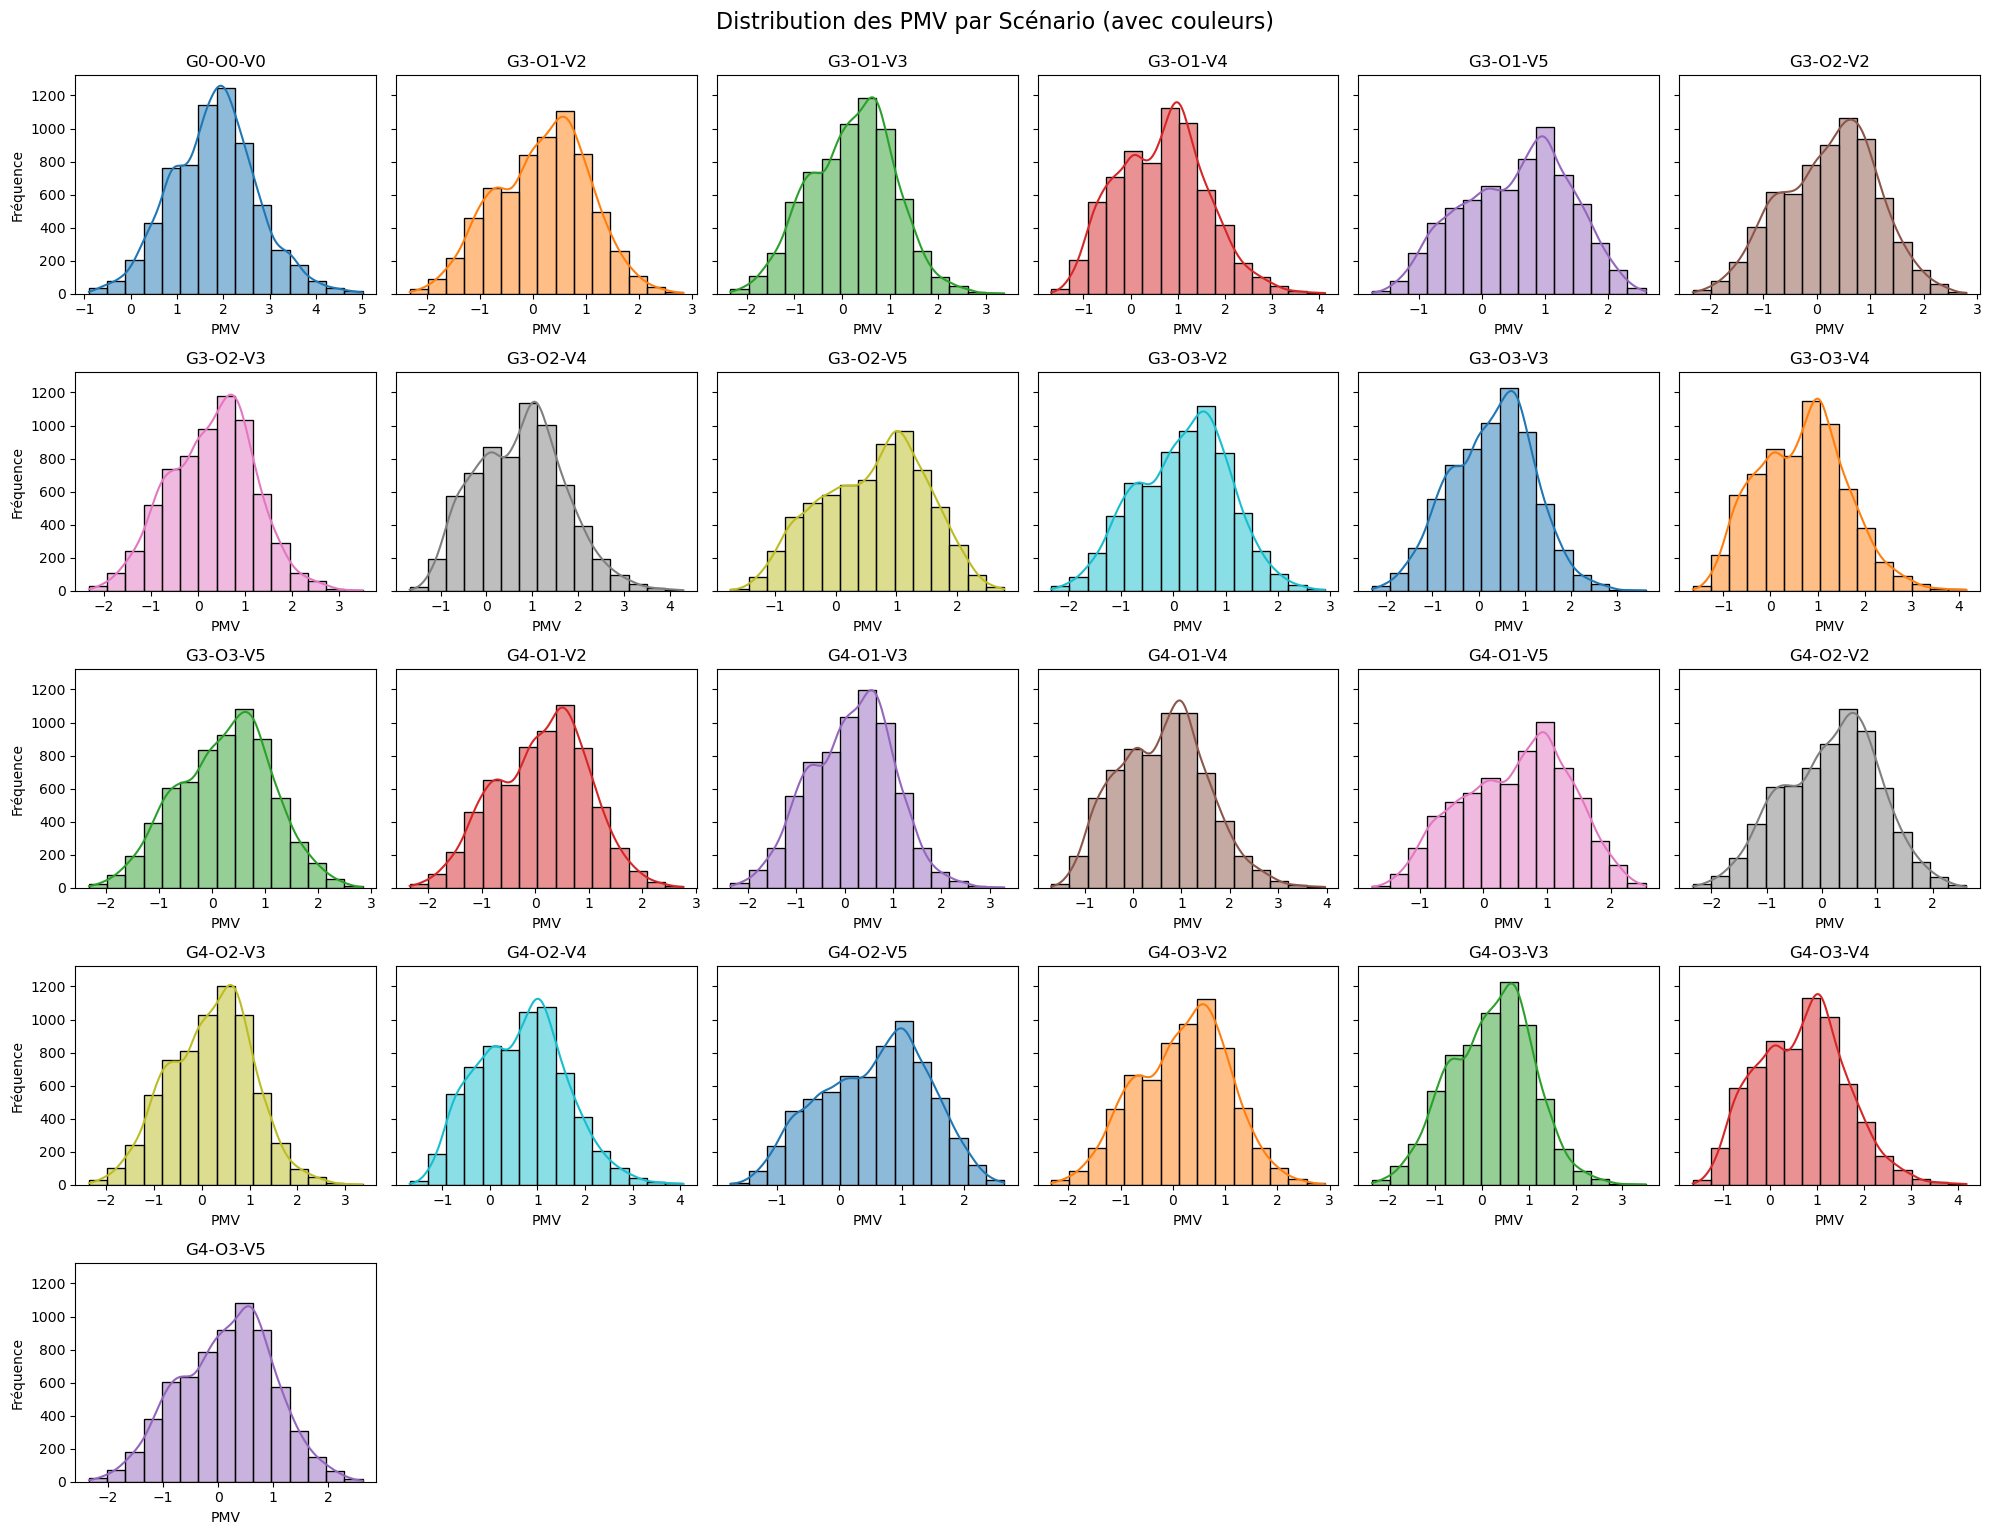

In [11]:
# =======================================================================
# Graphique 6 : Distribution des PMV par sc√©nario
# =======================================================================
df_pmv = df[df['Indicateur'] == "Fanger PMV"]
scenarios = df_pmv['Sc√©nario'].unique()

fig, axes = plt.subplots(nrows=len(scenarios) // 6 + 1, ncols=6, figsize=(20, 15), sharey=True)
axes = axes.flatten()

for i, scenario in enumerate(scenarios):
    sns.histplot(
        df_pmv[df_pmv['Sc√©nario'] == scenario]['Valeur'], 
        bins=15, kde=True, ax=axes[i], color=f"C{i % 10}"
    )
    axes[i].set_title(scenario)
    axes[i].set_xlabel("PMV")
    axes[i].set_ylabel("Fr√©quence")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Distribution des PMV par Sc√©nario (avec couleurs)", y=1.02, fontsize=16)
plt.show()

In [77]:
# =======================================================================
# Graphique 7 : √âvolution du PMV et du PPD
# =======================================================================

app = Dash(__name__)

# Layout de l'application Dash
app.layout = html.Div([
    html.H1("√âvolution du PMV et du PPD", style={'text-align': 'center'}),
    
    html.Div([
        html.Label("S√©lectionner un ou plusieurs sc√©narios :"),
        dcc.Dropdown(
            id='scenario-dropdown',
            options=[{'label': s, 'value': s} for s in df['Sc√©nario'].unique()],
            value=[df['Sc√©nario'].unique()[0]],  # Valeur par d√©faut
            multi=True  # Permet la s√©lection multiple
        ),
    ], style={'width': '45%', 'display': 'inline-block', 'padding': '10px'}),
    
    html.Div([
        html.Label("S√©lectionner une zone :"),
        dcc.Dropdown(
            id='zone-dropdown',
            options=[{'label': z, 'value': z} for z in df['Zone'].unique()],
            value=df['Zone'].unique()[0]  # Valeur par d√©faut
        ),
    ], style={'width': '45%', 'display': 'inline-block', 'padding': '10px'}),
    
    html.Div([dcc.Graph(id='pmv-graph'),  # Graphique pour le PMV
              dcc.Graph(id='ppd-graph')])   # Graphique pour le PPD
])

# Callback pour mettre √† jour les graphiques
@app.callback(
    [Output('pmv-graph', 'figure'),
     Output('ppd-graph', 'figure')],
    [Input('scenario-dropdown', 'value'), 
     Input('zone-dropdown', 'value')]
)
def update_graphs(selected_scenarios, selected_zone):
    if not selected_scenarios:
        return px.line(title="Aucun sc√©nario s√©lectionn√©"), px.line(title="Aucun sc√©nario s√©lectionn√©")
    
    # Filtrer les donn√©es pour les sc√©narios et la zone s√©lectionn√©s
    filtered_df = df[(df['Sc√©nario'].isin(selected_scenarios)) & (df['Zone'] == selected_zone)].copy()

    # V√©rifier si des donn√©es sont disponibles apr√®s filtrage
    if filtered_df.empty:
        return px.line(title="Aucune donn√©e pour le PMV"), px.line(title="Aucune donn√©e pour le PPD")
    
    # Trier les donn√©es par Date/Heure
    filtered_df = filtered_df.sort_values(by='Date/Heure')

    # Graphique pour le PMV
    pmv_df = filtered_df[filtered_df['Indicateur'] == "Fanger PMV"]
    pmv_fig = px.line(
        pmv_df,
        x='Date/Heure',
        y='Valeur',
        color='Sc√©nario',  # Diff√©rencier les sc√©narios par couleur
        title=f"√âvolution du PMV - Zone : {selected_zone}",
        labels={'Valeur': 'PMV', 'Date/Heure': 'Temps'},
        line_shape='linear'  # Retirer les points, uniquement des lignes
    )
    pmv_fig.update_layout(
        height=400,
        width=800,
        legend_title_text="Sc√©narios",
        margin=dict(l=20, r=20, t=50, b=20)
    )
    
    # Graphique pour le PPD
    ppd_df = filtered_df[filtered_df['Indicateur'] == "PPD"]
    ppd_fig = px.line(
        ppd_df,
        x='Date/Heure',
        y='Valeur',
        color='Sc√©nario',  # Diff√©rencier les sc√©narios par couleur
        title=f"√âvolution du PPD - Zone : {selected_zone}",
        labels={'Valeur': 'PPD (%)', 'Date/Heure': 'Temps'},
        line_shape='linear'  # Retirer les points, uniquement des lignes
    )
    ppd_fig.update_layout(
        height=400,
        width=800,
        legend_title_text="Sc√©narios",
        margin=dict(l=20, r=20, t=50, b=20)
    )
    
    return pmv_fig, ppd_fig

# Lancer l'application Dash
if __name__ == '__main__':
    app.run_server(debug=True, port=8072)

In [78]:
# =======================================================================
# Graphique 9 : Comparaison des Sc√©narios (Distribution des PMV)
# =======================================================================

# Application Dash
app = Dash(__name__)

# Layout de l'application
app.layout = html.Div([
    html.H1("Comparaison des Sc√©narios (Courbes de densit√© des PMV)", style={'text-align': 'center'}),
    
    html.Div([
        html.Label("S√©lectionner les sc√©narios :"),
        dcc.Dropdown(
            id='scenario-dropdown',
            options=[{'label': s, 'value': s} for s in df['Sc√©nario'].unique()],
            value=[df['Sc√©nario'].unique()[0]],  # Valeurs par d√©faut
            multi=True  # Permet de choisir plusieurs sc√©narios
        ),
    ], style={'width': '45%', 'display': 'inline-block', 'padding': '10px'}),
    
    html.Div([
        html.Label("S√©lectionner une zone thermique :"),
        dcc.Dropdown(
            id='zone-dropdown',
            options=[{'label': z, 'value': z} for z in df['Zone'].unique()],
            value=df['Zone'].unique()[0]  # Valeur par d√©faut
        ),
    ], style={'width': '45%', 'display': 'inline-block', 'padding': '10px'}),
    
    dcc.Graph(id='pmv-density-curve'),
])

# Callback pour mettre √† jour le graphique
@app.callback(
    Output('pmv-density-curve', 'figure'),
    [Input('scenario-dropdown', 'value'), Input('zone-dropdown', 'value')]
)
def update_graph(selected_scenarios, selected_zone):
    # Filtrer les donn√©es pour les sc√©narios s√©lectionn√©s et la zone
    filtered_df = df[(df['Sc√©nario'].isin(selected_scenarios)) & 
                     (df['Zone'] == selected_zone) & 
                     (df['Indicateur'] == "Fanger PMV")]
    
    # Cr√©er une figure vide
    fig = go.Figure()

    for scenario in selected_scenarios:
        # Extraire les valeurs pour le sc√©nario
        scenario_df = filtered_df[filtered_df['Sc√©nario'] == scenario]['Valeur']

        if not scenario_df.empty:
            # Calculer une courbe de densit√©
            kde = gaussian_kde(scenario_df)
            x_vals = np.linspace(scenario_df.min() - 0.5, scenario_df.max() + 0.5, 500)
            y_vals = kde(x_vals)
            
            # Ajouter une trace pour la courbe
            fig.add_trace(go.Scatter(
                x=x_vals, y=y_vals, mode='lines', name=scenario,
                line=dict(width=2)  # Personnalisation de la ligne
            ))

    # Mettre √† jour les param√®tres du graphique
    fig.update_layout(
        title=f"Courbes de densit√© des PMV (Zone : {selected_zone})",
        xaxis_title="PMV",
        yaxis_title="Densit√©",
        height=600,
        width=1000,
        legend_title="Sc√©narios",
    )

    return fig

# Lancer l'application
if __name__ == '__main__':
    app.run_server(debug=True, port=8074)

In [79]:
# =======================================================================
# Graphique 11 : Analyse des indicateurs par sc√©nario
# =======================================================================

# Pr√©paration des donn√©es

# Liste des indicateurs disponibles
indicateurs = ["Fanger PMV", "PPD", "Temp√©rature op√©rative", "Heures d'inconfort (tout type de v√™tement)"]

# Cr√©ation de l'application Dash
app = Dash(__name__)

# Layout de l'application
app.layout = html.Div([
    html.H1("Analyse des indicateurs par sc√©nario", style={'text-align': 'center'}),

    # Filtres interactifs
    html.Div([
        html.Div([
            html.Label("S√©lectionner la mesure statistique :"),
            dcc.Dropdown(
                id='statistic-dropdown',
                options=[
                    {'label': 'M√©diane', 'value': 'median'},
                    {'label': 'Moyenne', 'value': 'mean'},
                    {'label': 'Moyenne des valeurs absolues', 'value': 'mean_abs'},
                    {'label': 'Int√©grale', 'value': 'integral'}
                ],
                value='median',  # Valeur par d√©faut
                multi=False
            ),
        ], style={'width': '45%', 'display': 'inline-block', 'padding': '10px'}),

        html.Div([
            html.Label("S√©lectionner un indicateur :"),
            dcc.Dropdown(
                id='indicator-dropdown',
                options=[{'label': indic, 'value': indic} for indic in indicateurs],
                value='Fanger PMV',  # Valeur par d√©faut
                multi=False
            ),
        ], style={'width': '45%', 'display': 'inline-block', 'padding': '10px'}),
    ]),

    # Graphique interactif
    dcc.Graph(id='indicator-graph')
])

# Callback pour mettre √† jour le graphique
@app.callback(
    Output('indicator-graph', 'figure'),
    [Input('statistic-dropdown', 'value'),
     Input('indicator-dropdown', 'value')]
)
def update_graph(selected_statistic, selected_indicator):
    # Filtrer les donn√©es pour l'indicateur s√©lectionn√©
    filtered_df = df[df['Indicateur'] == selected_indicator]

    # Calcul de la statistique par sc√©nario
    if selected_statistic == 'median':
        stat_df = filtered_df.groupby('Sc√©nario')['Valeur'].median().reset_index(name='Valeur')
        title = f"M√©diane de {selected_indicator} par sc√©nario"
    elif selected_statistic == 'mean':
        stat_df = filtered_df.groupby('Sc√©nario')['Valeur'].mean().reset_index(name='Valeur')
        title = f"Moyenne de {selected_indicator} par sc√©nario"
    elif selected_statistic == 'mean_abs':
        stat_df = filtered_df.groupby('Sc√©nario')['Valeur'].apply(lambda x: abs(x).mean()).reset_index(name='Valeur')
        title = f"Moyenne des valeurs absolues de {selected_indicator} par sc√©nario"
    elif selected_statistic == 'integral':
        # Approximation de l'int√©grale (somme des valeurs)
        stat_df = filtered_df.groupby('Sc√©nario')['Valeur'].sum().reset_index(name='Valeur')
        title = f"Int√©grale (aire sous la courbe) de {selected_indicator} par sc√©nario"

    # Cr√©er le graphique
    fig = px.bar(
        stat_df,
        x='Sc√©nario',
        y='Valeur',
        title=title,
        labels={'Valeur': selected_indicator, 'Sc√©nario': 'Sc√©nario'},
        height=600
    )

    # Ajuster les options de mise en page
    fig.update_layout(
        xaxis=dict(title="Sc√©nario", tickangle=45),
        yaxis=dict(title=f"Valeur ({selected_indicator})"),
        margin=dict(l=20, r=20, t=50, b=20)
    )

    return fig

# Lancer l'application
if __name__ == '__main__':
    app.run_server(debug=True, port=8076)

In [80]:
# =======================================================================
# Chargement et pr√©paration des donn√©es
# =======================================================================

# Convertir la colonne Date/Heure en datetime
df['Date/Heure'] = pd.to_datetime(df['Date/Heure'])

# Identifier les heures d‚Äôinconfort (> 0)
df['Inconfort'] = df['Valeur'] > 0

# Nouvelle approche : D√©tection stricte des s√©quences
def detect_inconfort_sequences(data):
    """ Fonction am√©lior√©e pour d√©tecter correctement les heures isol√©es d'inconfort et les s√©quences. """
    result = []

    for (zone, scenario), group in data.groupby(["Zone", "Sc√©nario"]):
        group = group.sort_values("Date/Heure")  # Trier par temps
        
        # Cr√©ation d'un identifiant de s√©quence unique
        group['Groupe'] = (group['Inconfort'] != group['Inconfort'].shift()).cumsum()
        
        # Regroupement des s√©quences
        grouped = group.groupby(['Groupe', 'Inconfort']).size().reset_index(name='Dur√©e')

        for _, row in grouped.iterrows():
            if row['Inconfort']:  # Ne conserver que les p√©riodes d'inconfort
                result.append({"Zone": zone, "Sc√©nario": scenario, "Dur√©e": row['Dur√©e']})

    return pd.DataFrame(result)

# Appliquer la d√©tection des s√©quences
df_inconfort_sequences = detect_inconfort_sequences(df)


# Regrouper les dur√©es d‚Äôinconfort en plages
df_inconfort_sequences['Plage_dur√©e'] = pd.cut(
    df_inconfort_sequences['Dur√©e'],
    bins=[0, 1, 2, 4, 6, 12, 24, float('inf')],
    labels=['1h', '2h', '3-4h', '5-6h', '7-12h', '13-24h', '24+h'],
    right=True
)

# Compter les occurrences des dur√©es d'inconfort par sc√©nario et zone
df_durations_summary = df_inconfort_sequences.groupby(['Zone', 'Sc√©nario', 'Plage_dur√©e']).size().reset_index(name='Occurrences')


# =======================================================================
# Cr√©ation de l'application Dash
# =======================================================================

app = Dash(__name__)

# Layout de l'application
app.layout = html.Div([
    html.H1("Analyse des dur√©es d'inconfort", style={'text-align': 'center'}),

    # S√©lection des zones et sc√©narios
    html.Div([
        html.Div([
            html.Label("S√©lectionner une zone thermique :"),
            dcc.Dropdown(
                id='zone-dropdown',
                options=[{'label': zone, 'value': zone} for zone in df_durations_summary['Zone'].unique()],
                value=df_durations_summary['Zone'].unique()[0],  # Valeur par d√©faut
                multi=False
            ),
        ], style={'width': '45%', 'display': 'inline-block', 'padding': '10px'}),

        html.Div([
            html.Label("S√©lectionner un ou plusieurs sc√©narios :"),
            dcc.Dropdown(
                id='scenario-dropdown',
                options=[{'label': scenario, 'value': scenario} for scenario in df_durations_summary['Sc√©nario'].unique()],
                multi=True,
                value=df_durations_summary['Sc√©nario'].unique()[:3]  # S√©lection par d√©faut
            ),
        ], style={'width': '45%', 'display': 'inline-block', 'padding': '10px'}),
    ]),

    # Graphique interactif
    dcc.Graph(id='inconfort-graph')
])

# =======================================================================
# Callback pour mettre √† jour le graphique
# =======================================================================

@app.callback(
    Output('inconfort-graph', 'figure'),
    [Input('zone-dropdown', 'value'),
     Input('scenario-dropdown', 'value')]
)
def update_graph(selected_zone, selected_scenarios):
    # Filtrer les donn√©es en fonction des s√©lections
    filtered_df = df_durations_summary[
        (df_durations_summary['Zone'] == selected_zone) &
        (df_durations_summary['Sc√©nario'].isin(selected_scenarios))
    ]


    # Cr√©er le graphique interactif
    fig = px.bar(
        filtered_df,
        x='Plage_dur√©e', 
        y='Occurrences', 
        color='Sc√©nario',
        barmode='group',
        title=f"Dur√©es cons√©cutives d'inconfort - Zone : {selected_zone}",
        labels={'Plage_dur√©e': 'Dur√©es cons√©cutives (heures)', 'Occurrences': 'Nombre d\'occurrences'},
        height=600
    )

    # Ajuster la mise en page
    fig.update_layout(
        showlegend=True,
        legend_title_text="Sc√©narios",
        margin=dict(l=20, r=20, t=40, b=20),
        font=dict(size=10)
    )

    return fig

# Lancer l'application
if __name__ == '__main__':
    app.run_server(debug=True, port=8078)

In [62]:
# ============================
# üìä Pr√©paration du Tableau Multi-Tri Simultan√©
# ============================

# Chargement des donn√©es existantes
df_table = df_table.copy()

# Ajout des classements pour chaque indicateur (ordre croissant)
df_table['Rang_PMV'] = df_table['PMV'].rank(method="min", ascending=True).astype(int)
df_table['Rang_PPD'] = df_table['PPD'].rank(method="min", ascending=True).astype(int)
df_table['Rang_ISI'] = df_table['ISI'].rank(method="min", ascending=True).astype(int)
df_table['Rang_Heures'] = df_table['Total_Heures'].rank(method="min", ascending=True).astype(int)

# R√©organisation des colonnes
df_table_sorted = df_table[['Sc√©nario', 'PMV', 'Rang_PMV', 'PPD', 'Rang_PPD', 'ISI', 'Rang_ISI', 'Total_Heures', 'Rang_Heures']]

# Tri global des sc√©narios par ordre croissant de PMV, PPD et ISI
df_table_sorted = df_table_sorted.sort_values(by=['Rang_PMV', 'Rang_PPD', 'Rang_ISI'], ascending=[True, True, True])

# Affichage du tableau final
print(df_table_sorted)  # üìå Affichage dans la console

    Sc√©nario       PMV  Rang_PMV        PPD  Rang_PPD         ISI  Rang_ISI  \
14  G4-O1-V3  0.710744         1  20.134367         1   43.389577         2   
24  G4-O3-V5  0.711627         2  20.179818         2   42.018724         1   
13  G4-O1-V2  0.714271         3  20.250809         3   44.185426         3   
17  G4-O2-V2  0.725253         4  20.564406         4   46.344269        10   
18  G4-O2-V3  0.726758         5  20.653281         5   45.254897         4   
22  G4-O3-V3  0.736624         6  21.009413         6   45.926961         9   
2   G3-O1-V3  0.736831         7  21.060064         8   45.753854         6   
21  G4-O3-V2  0.737410         8  21.028935         7   45.755690         7   
1   G3-O1-V2  0.738255         9  21.103187         9   46.499565        11   
9   G3-O3-V2  0.740782        10  21.163391        10   45.868956         8   
12  G3-O3-V5  0.751627        11  21.616591        11   45.637609         5   
5   G3-O2-V2  0.759361        12  21.801345        

In [81]:
from dash import Dash, dcc, html, dash_table, Input, Output
import pandas as pd

# ============================
# üìä Cr√©ation de l'Application Dash - Vue Multicolonne
# ============================

# Cr√©ation de l'application Dash
app = Dash(__name__)

app.layout = html.Div([
    html.H1("Comparaison Dynamique des Classements", style={'text-align': 'center'}),

    # S√©lecteur de tri
    html.Div([
        html.Label("Trier par :"),
        dcc.Dropdown(
            id='sort-dropdown',
            options=[
                {'label': 'PMV (croissant)', 'value': 'Rang_PMV'},
                {'label': 'PPD (croissant)', 'value': 'Rang_PPD'},
                {'label': 'S√©v√©rit√© d‚ÄôInconfort (ISI)', 'value': 'Rang_ISI'},
                {'label': 'Total Heures (croissant)', 'value': 'Rang_Heures'}
            ],
            value='Rang_PMV',
            multi=False
        ),
    ], style={'width': '50%', 'margin': 'auto'}),

    # Tableau interactif
    dash_table.DataTable(
        id='table',
        columns=[
            {'name': 'Sc√©nario', 'id': 'Sc√©nario'},
            {'name': 'PMV', 'id': 'PMV', 'type': 'numeric', 'format': {'specifier': ".3f"}},
            {'name': 'Rang PMV', 'id': 'Rang_PMV'},
            {'name': 'PPD', 'id': 'PPD', 'type': 'numeric', 'format': {'specifier': ".3f"}},
            {'name': 'Rang PPD', 'id': 'Rang_PPD'},
            {'name': 'ISI (Inconfort)', 'id': 'ISI', 'type': 'numeric', 'format': {'specifier': ".3f"}},
            {'name': 'Rang ISI', 'id': 'Rang_ISI'},
            {'name': 'Total Heures', 'id': 'Total_Heures', 'type': 'numeric', 'format': {'specifier': ".3f"}},
            {'name': 'Rang Heures', 'id': 'Rang_Heures'}
        ],
        data=df_table_sorted.to_dict('records'),
        style_table={'overflowX': 'auto'},
        style_cell={'textAlign': 'center', 'padding': '5px'},
        style_header={'backgroundColor': 'lightblue', 'fontWeight': 'bold'},
        style_data_conditional=[
            {'if': {'row_index': 0}, 'backgroundColor': '#FFD700', 'color': 'black', 'fontWeight': 'bold'},  # ü•á Or
            {'if': {'row_index': 1}, 'backgroundColor': '#C0C0C0', 'color': 'black', 'fontWeight': 'bold'},  # ü•à Argent
            {'if': {'row_index': 2}, 'backgroundColor': '#CD7F32', 'color': 'black', 'fontWeight': 'bold'},  # ü•â Bronze
        ],
    )
])

# Callback pour mettre √† jour le tri
@app.callback(
    Output('table', 'data'),
    [Input('sort-dropdown', 'value')]
)
def update_table(selected_sort):
    df_sorted = df_table_sorted.sort_values(by=selected_sort, ascending=True)
    return df_sorted.to_dict('records')

# ============================
# Lancement de l'application
# ============================
if __name__ == '__main__':
    app.run_server(debug=True, port=8083)

In [82]:
from dash import Dash, dcc, html, dash_table, Input, Output
import pandas as pd

# ============================
# üìä Cr√©ation de l'Application Dash - Vue Multicolonne
# ============================

# Cr√©ation de l'application Dash
app = Dash(__name__)

app.layout = html.Div([
    html.H1("Comparaison Dynamique des Classements", style={'text-align': 'center'}),

    # S√©lecteur de tri
    html.Div([
        html.Label("Trier par :"),
        dcc.Dropdown(
            id='sort-dropdown',
            options=[
                {'label': 'PMV (croissant)', 'value': 'Rang_PMV'},
                {'label': 'PPD (croissant)', 'value': 'Rang_PPD'},
                {'label': 'S√©v√©rit√© d‚ÄôInconfort (ISI)', 'value': 'Rang_ISI'},
                {'label': 'Total Heures (croissant)', 'value': 'Rang_Heures'}
            ],
            value='Rang_PMV',
            multi=False
        ),
    ], style={'width': '50%', 'margin': 'auto'}),

    # Tableau interactif
    dash_table.DataTable(
        id='table',
        columns=[
            {'name': 'Sc√©nario', 'id': 'Sc√©nario'},
            {'name': 'PMV', 'id': 'PMV', 'type': 'numeric', 'format': {'specifier': ".3f"}},
            {'name': 'Rang PMV', 'id': 'Rang_PMV'},
            {'name': 'PPD', 'id': 'PPD', 'type': 'numeric', 'format': {'specifier': ".3f"}},
            {'name': 'Rang PPD', 'id': 'Rang_PPD'},
            {'name': 'ISI (Inconfort)', 'id': 'ISI', 'type': 'numeric', 'format': {'specifier': ".3f"}},
            {'name': 'Rang ISI', 'id': 'Rang_ISI'},
            {'name': 'Total Heures', 'id': 'Total_Heures', 'type': 'numeric', 'format': {'specifier': ".3f"}},
            {'name': 'Rang Heures', 'id': 'Rang_Heures'}
        ],
        data=df_table_sorted.to_dict('records'),
        style_table={'overflowX': 'auto'},
        style_cell={'textAlign': 'center', 'padding': '5px'},
        style_header={'backgroundColor': 'lightblue', 'fontWeight': 'bold'},
        style_data_conditional=[
            {'if': {'row_index': 0}, 'backgroundColor': '#FFD700', 'color': 'black', 'fontWeight': 'bold'},  # ü•á Or
            {'if': {'row_index': 1}, 'backgroundColor': '#C0C0C0', 'color': 'black', 'fontWeight': 'bold'},  # ü•à Argent
            {'if': {'row_index': 2}, 'backgroundColor': '#CD7F32', 'color': 'black', 'fontWeight': 'bold'},  # ü•â Bronze
        ],
    ),

    # ‚úÖ Bouton pour exporter l'HTML interactif
    html.Button("Exporter en HTML", id="btn-download", n_clicks=0),
    dcc.Download(id="download-html")
])

# Callback pour mettre √† jour le tri
@app.callback(
    Output('table', 'data'),
    [Input('sort-dropdown', 'value')]
)
def update_table(selected_sort):
    df_sorted = df_table_sorted.sort_values(by=selected_sort, ascending=True)
    return df_sorted.to_dict('records')

# ‚úÖ Callback pour exporter en fichier HTML
@app.callback(
    Output("download-html", "data"),
    Input("btn-download", "n_clicks"),
    prevent_initial_call=True
)
def export_html(n_clicks):
    file_path = "tableau_interactif.html"
    
    # G√©n√©rer une page HTML contenant l'application Dash
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(app.index_string)
    
    return dcc.send_file(file_path)

# ============================
# Lancement de l'application
# ============================
if __name__ == '__main__':
    app.run_server(debug=True, port=8084)